<i>STATUS: Draft<i>

In [2]:
import numpy as np
import sympy as sp
from IPython.display import HTML
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.patches import Rectangle
from IPython.display import Image
import sys

In the last notebook, we finished getting a handle on SDRS...now SDRS...

IN this notebook we are also going to move toward using the htm.core code. An encoder

Its important to note a very big disclaimer here: this notebook really owes a huge amount to - <a href="https://buildinghtmsystems.wpcomstaging.com/encoders/">https://buildinghtmsystems.wpcomstaging.com/encoders/</a>. I have been careful to attibute your work. I encourage. I wanted to use htm.core and python generally to approach this, but will point out. It's extemely well written. 

HOw to get data from real world into SDRS - cochliea, neural activity....goes in

Cochlea goes into neural

Data must be encoded into sparse binary arrays for an HTM system to process it. These binary arrays define an input space for the Spatial Pooling algorithm. SDRs stream across this input space as spatial patterns over time. Spatial patterns must contain semantic meaning within their representations in order for HTM systems to process them.



I have rather shamesly plagearised some of the work here

<i>"SDRs are quite different from standard computer representations, such as ASCII for text, in that meaning is encoded directly into the representation. An SDR consists of a large array of bits of which most are zeros and a few are ones. Each bit carries some semantic meaning, so if two SDRs have more than a few overlapping one-bits, then those two SDRs have similar meanings.

JG _ QUOTE....
One important aspect of the cochlear encoding process is that each hair cell responds to a range of frequencies, and the ranges overlap with other nearby hair cells. This characteristic provides redundancy in case some hair cells are damaged but also means that a given frequency will stimulate multiple cells. And two sounds with similar frequencies will have some overlap in the cells that are stimulated. This overlap between representations is how the semantic similarity of the data is captured in the representation. It also means that the semantic meaning is distributed across a set of active cells, making the representation tolerant to noise or subsampling.

The cochleae for different animals respond to different ranges of frequencies and have different resolutions for which they can distinguish differences in the frequencies. While very high frequency sounds might be important for some animals to hear precisely, they might not be useful to others. Similarly, the design of an encoder is dependent on the type of data. The encoder must capture the semantic characteristics of the data that are important for your application. Many of the encoder implementations in NuPIC take range or resolution parameters that allow them to work for a broad range of applications.
$^1$</i><br/>

In [25]:
#################### SINGLE SDR FUNCTIONS ###################################################


def create_randomised_sdr(capacity, population):
    sdr = set()
    while len(sdr) < population:
        sdr.add(np.random.randint(low=1, high=capacity))

    return(list(sdr))


def randomly_flip_percentage_of_bits(SDR, array_size, percentage_to_flip):
    to_remove = int(percentage_to_flip * len(SDR))
    randomised_SDR = np.random.shuffle(SDR)
    del SDR[0:to_remove]
    noise = create_randominsed_sdr(np.sqrt(array_size), np.sqrt(array_size), to_remove)
    sdr_with_noise = noise + SDR
    return(sdr_with_noise)


############## MULTIPLE SDR FUNCTIONS ###################################################
def compute_union_and_overlap(SDR1_on_bits, SDR2_on_bits):
    union = list(set(SDR1_on_bits).union(SDR2_on_bits))
    overlap = list(set(SDR1_on_bits).intersection(SDR2_on_bits))
    
    return({"union": union, "overlap": overlap})

def create_and_compare_sdrs_over_multiple_iterations(iterations, sdr_size, population):
    sdr_unions_for_comparison = []
    sdr_overlaps_for_comparison = []
    for x in range(iterations):
        SDR1 = create_randominsed_sdr(sdr_size, population)
        SDR2 =create_randominsed_sdr(sdr_size, population)
        sdr_comparison = compute_union_and_overlap(SDR1, SDR2)
        sdr_unions_for_comparison.append(len(sdr_comparison['union']))
        sdr_overlaps_for_comparison.append(len(sdr_comparison['overlap']))
    print("Average union: ", str(sum(sdr_unions_for_comparison) / len(sdr_unions_for_comparison)))
    print("Average overlap: ", str(sum(sdr_overlaps_for_comparison) / len(sdr_overlaps_for_comparison)))
    return({"union_comparison": sdr_unions_for_comparison, "overlap_comparison": sdr_overlaps_for_comparison})

def compute_overlap_set_cardinality(n, w0, w1, b, provide_summary = True):
    on_bit_space = sp.binomial(w0, b)
    off_bit_space = sp.binomial(n - w0, w1 - b)
    overlap_set = on_bit_space * off_bit_space
    if provide_summary:
        print("Given a capcity of", str(w0), "bits in the on-bit space, the number of ways to arrange ", str(b), "on-bits: ", on_bit_space)
        print("Given a capacity", str(n - w0), "bits in the off-bit space, the number of ways to arrange", str(w1 - b), "off-bits: ", off_bit_space)
        print("Number of SDRs that will match w0: ", overlap_set)
    return(overlap_set)

######################## VISUALISATION FUNCTIONS ############################################

def convert_sdr_to_tuple_for_visualisation(sdr):
    pass

def create_axis_for_sdr(ax, x_limit, y_limit, population, label, create_label = True):
    
    if create_label:
        label_add = np.round((population / (x_limit * y_limit)) * 100, 2)
        label = label + ' (Sparsity: {}%)'.format(label_add)
        ax.set_xlabel(label)
        
    ax.set_xticks(range(int(x_limit)))
    ax.set_yticks(range(int(y_limit)))
    [ax.xaxis.get_major_ticks()[i].tick1line.set_color("white") for i in range(int(x_limit))]
    [ax.yaxis.get_major_ticks()[i].tick1line.set_color("white") for i in range(int(y_limit))]
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.grid(color='k', linestyle='-', linewidth=.5)
    
    return(ax)


In [26]:
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/V3Yqtpytif0" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

1. Semantically similar data should result in SDRs with overlapping active bits.

2. The same input should always produce the same SDR as output.

3. The output should have the same dimensionality (total number of bits) for all inputs.

4. The output should have similar sparsity for all inputs and have enough one-bits to handle noise and
    subsampling.
    

<b>Semantically similar data should result in SDRs with overlapping active bits.</b><br/>

To create an effective encoder, you must understand the aspects of your data that should contribute to similarity. In the cochlea example above, the encoder was designed to make sounds with similar pitch have similar representations but did not take into account how loud the sounds were, which would require a different approach.

The first step to designing an encoder is to determine each of the aspects of the data that you want to capture. For sound, the key features may be pitch and amplitude; for dates, it may be whether or not it is a weekend.

The encoder should create representations that overlap for inputs that are similar in one or more of the characteristics of the data that were chosen. So for weekend encoders, dates that fall on Saturdays and Sundays should overlap with each other, but not as much or at all with dates that fall on weekdays.

<b>The same input should always produce the same SDR as output</b><br/>

Encoders should be deterministic so that the same input produces the same output every time. Without this property, the sequences learned in an HTM system will become obsolete as the encoded representations for values change. Avoid creating encoders with random or adaptive elements.
It can be tempting to create adaptive encoders that adjust representations to handle input data with an unknown range. There is a way to design an encoder to handle this case without changing the representations of inputs that is described below in the section labeled “A more flexible encoder method.” This method allows encoders to handle input with unbounded or unknown ranges.


<b>The output should have the same dimensionality (total number of bits) for all inputs</b><br/>

The output of an encoder must always produce the same number of bits for each of its inputs. SDRs are compared and operated on using a bit-by-bit assumption such that a bit with a certain “meaning” is always in the same position. If the encoders produced varying bit lengths for the SDRs, comparisons and other operations would not be possible.

<b>The output should have similar sparsity for all inputs and have enough one-bits to handle noise and subsampling</b><br/>

The fraction of total ON bits in an encoder can vary from around 1% to 35%, but the sparsity should be relatively fixed for a given application of an encoder. While keeping the sparsity the same should be the rule, small variations in sparsity will not have a negative effect.
Additionally, there must be enough one-bits to handle noise and subsampling. A general rule of thumb is to have at least 20-25 one bits. Encoders that produce representations with fewer than 20 one bits do not work well in HTM systems since they may become extremely susceptible to errors due to small amounts of noise or non-determinism.

Let's build an encorder and start with numbers, numbers are bit overly simple

We can have following values


In [27]:
n = 12
w = 4
min_value = 0
max_value = 55

scaler_value_to_encode = 50

compare_periodic = False
use_periodic_encoder = False

# number of buckets - places to put stuff in
n - w

# should automatically 

# 1. create possible buckets
# 2. assign all values to buckets
# 3. look at comparison values, adjacent or not

8

In [28]:
n - w + 1

9

In [29]:
def create_scalar_encoder_values(n, w, min_val, max_val):
    bucket_capacity = n - w + 1
    
    #return(bucket_index)

In [30]:
809 / 1560

0.5185897435897436

In [249]:
def convert_sdr_to_tuple_for_visualisation(sdr, sdr_size):
    
    # create array of complete sdrs
    m = np.zeros(sdr_size)
    for i in sdr:
        m[i] = m[i] + 1
    
    # find dimensions of visualisation
    n = sp.symbols('n')
    e = sp.Eq(2**n, sdr_size)
    s = sp.solve(e, n)
    middle_index = np.floor(float(s[0] / 2))
    
    if s[0] % 2 == 0:
        dimensions = [2**middle_index, 2**middle_index]
    else:
        dimensions = [2**middle_index, 2**(middle_index + 1)]
        
    print(dimensions)
    
    d = np.reshape(m, [int(v) for v in dimensions])
    x_vals, y_vals = np.where(d == 1)
    
    print(x_vals)
    
    return([x_vals, y_vals])

    
sdr_size = 256
population = 32
specs1 = create_randomised_sdr(sdr_size, population)
convert_sdr_to_tuple_for_visualisation(specs1, sdr_size)

[16.0, 16.0]
[ 0  0  0  0  1  1  2  3  3  3  4  4  6  6  7  7  7  7  8  9 11 11 12 12
 13 13 14 14 14 15 15 15]


[array([ 0,  0,  0,  0,  1,  1,  2,  3,  3,  3,  4,  4,  6,  6,  7,  7,  7,
         7,  8,  9, 11, 11, 12, 12, 13, 13, 14, 14, 14, 15, 15, 15]),
 array([ 1,  8,  9, 15,  3,  9,  8,  1, 11, 13,  7, 14, 13, 15,  0, 10, 11,
        15, 15,  3,  1, 13,  1,  7,  0,  2,  3,  6,  9,  3, 13, 14])]

In [208]:
x = np.zeros(10)
x

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [210]:
np.reshape(x, (5,2))

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])

[32.0, 32.0]
[ 0  8 14 16 17 21 24 30]


[array([ 0,  8, 14, 16, 17, 21, 24, 30]),
 array([27,  2, 28, 14,  4,  2, 27,  5])]

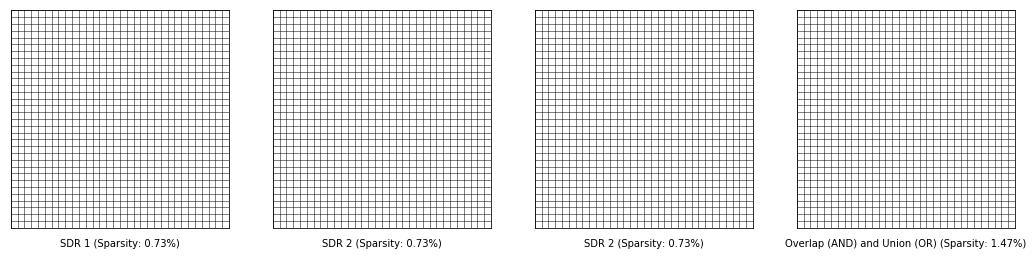

In [251]:
sdr_size = 1024
population = 8
label = str(np.round(sdr_size/population, 3))

specs1 = create_randomised_sdr(sdr_size, population)
specs2 = create_randomised_sdr(sdr_size, population)

x_vals, y_vals = sdr_comparison = compute_union_and_overlap(specs1, specs2)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(18, 4))

ax1 = create_axis_for_sdr(ax1, np.sqrt(sdr_size) + 1, np.sqrt(sdr_size) + 1, population, "SDR 1")
ax2 = create_axis_for_sdr(ax2, np.sqrt(sdr_size) + 1, np.sqrt(sdr_size) + 1, population, "SDR 2")
ax3 = create_axis_for_sdr(ax3, np.sqrt(sdr_size) + 1, np.sqrt(sdr_size) + 1, population, "SDR 2")
ax4 = create_axis_for_sdr(ax4, np.sqrt(sdr_size) + 1, np.sqrt(sdr_size) + 1, len(sdr_comparison['union']), "Overlap (AND) and Union (OR)")

convert_sdr_to_tuple_for_visualisation(specs1, sdr_size)

#SDR1 = [ax1.add_patch(Rectangle((3,4), 1, 1, color="blue")) for i in range(len(specs1))]
# SDR2 = [ax2.add_patch(Rectangle(specs2[i], 1, 1, color="blue")) for i in range(len(specs2))]
# SDR3 = [ax4.add_patch(Rectangle(specs2[i], 1, 1, color="blue")) for i in range(len(specs2))]
# union = [ax3.add_patch(Rectangle(sdr_comparison['union'][i], 1, 1, color="gray")) for i in range(len(sdr_comparison['union']))]
# overlap = [ax3.add_patch(Rectangle(sdr_comparison['overlap'][i], 1, 1, color="orange")) for i in range(len(sdr_comparison['overlap']))]


58738.78125*pi